In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1): 
        super(UNet, self).__init__()

        self.enc1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.bottleneck = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec1 = nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1)
        self.up3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec3 = nn.Conv2d(32 + 32, 32, kernel_size=3, padding=1)
        self.up4 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.dec4 = nn.Conv2d(16 + 16, 16, kernel_size=3, padding=1)

        self.out = nn.Conv2d(16, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = F.relu(self.enc1(x))
        p1 = F.max_pool2d(e1, 2)
    
        e2 = F.relu(self.enc2(p1))
        p2 = F.max_pool2d(e2, 2)
    
        e3 = F.relu(self.enc3(p2))
        p3 = F.max_pool2d(e3, 2)
    
        e4 = F.relu(self.enc4(p3))
        p4 = F.max_pool2d(e4, 2)
    
        b = F.relu(self.bottleneck(p4))
    
        u1 = self.up1(b)
        u1 = torch.cat([u1, e4], dim=1)
        d1 = F.relu(self.dec1(u1))
    
        u2 = self.up2(d1)
        u2 = torch.cat([u2, e3], dim=1)
        d2 = F.relu(self.dec2(u2))
    
        u3 = self.up3(d2)
        u3 = torch.cat([u3, e2], dim=1)
        d3 = F.relu(self.dec3(u3))
    
        u4 = self.up4(d3)
        u4 = torch.cat([u4, e1], dim=1)
        d4 = F.relu(self.dec4(u4))
        
        out = self.out(d4)
    
        return torch.sigmoid(out)


In [2]:
import os
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split

class HighlightDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_transform=None):
        self.image_dir = os.path.join(root_dir, "image")
        self.mask_dir = os.path.join(root_dir, "mask")
        self.transform = transform
        self.mask_transform = mask_transform

        # 共通のファイル番号を持つファイルのみを取得
        self.image_names = []
        for fname in os.listdir(self.image_dir):
            if fname.startswith("full_") and fname.endswith(".png"):
                id_part = fname[len("full_"):]  # 例: "0012.png"
                mask_name = f"mask_{id_part}"
                if os.path.exists(os.path.join(self.mask_dir, mask_name)):
                    self.image_names.append(id_part)  # "0012.png" を保存

        self.image_names.sort()  # 安定のためソート

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        id_part = self.image_names[idx]  # 例: "0012.png"

        img_path = os.path.join(self.image_dir, f"full_{id_part}")
        mask_path = os.path.join(self.mask_dir, f"mask_{id_part}")

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            mask = (mask > 0.5).float()  # 二値化（必要に応じて）

        return image, mask

image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),  # [0,1]に正規化
])

mask_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),  # float型で読み込み（0 or 1）
])

dataset = HighlightDataset(root_dir='dataset1',
                           transform=image_transform,
                           mask_transform=mask_transform)

total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # 残り全部

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

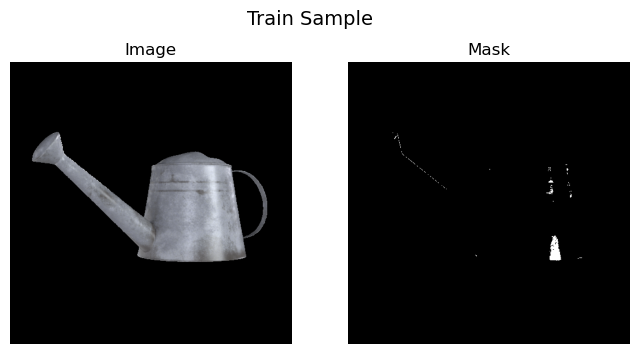

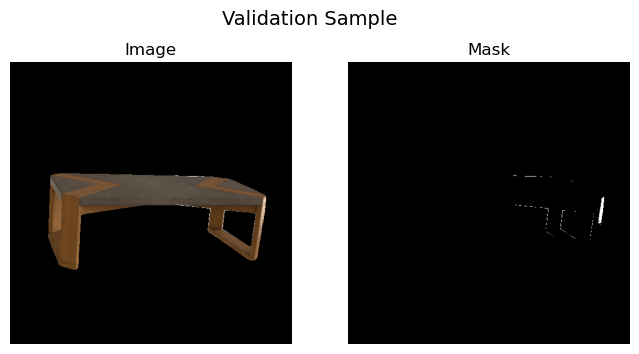

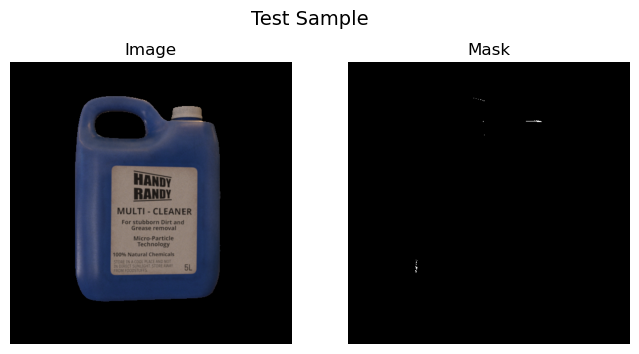

In [3]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def show_batch(dataset, title=""):
    image, mask = dataset[0]  # 任意のインデックス（例: 0）
    
    image_np = TF.to_pil_image(image)      # Tensor → PIL → numpy
    mask_np = TF.to_pil_image(mask)

    plt.figure(figsize=(8, 4))
    plt.suptitle(title, fontsize=14)
    
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title("Mask")
    plt.axis('off')
    
    plt.show()


show_batch(train_set, title="Train Sample")
show_batch(val_set, title="Validation Sample")
show_batch(test_set, title="Test Sample")


[Epoch 1/1000] Train Loss: 0.4642, Val Loss: 0.0429
[Epoch 2/1000] Train Loss: 0.0405, Val Loss: 0.0270
[Epoch 3/1000] Train Loss: 0.0275, Val Loss: 0.0230
[Epoch 4/1000] Train Loss: 0.0233, Val Loss: 0.0188
[Epoch 5/1000] Train Loss: 0.0201, Val Loss: 0.0173
[Epoch 6/1000] Train Loss: 0.0183, Val Loss: 0.0148
[Epoch 7/1000] Train Loss: 0.0168, Val Loss: 0.0139
[Epoch 8/1000] Train Loss: 0.0165, Val Loss: 0.0116
[Epoch 9/1000] Train Loss: 0.0151, Val Loss: 0.0109
[Epoch 10/1000] Train Loss: 0.0144, Val Loss: 0.0101
[Epoch 11/1000] Train Loss: 0.0140, Val Loss: 0.0098
[Epoch 12/1000] Train Loss: 0.0140, Val Loss: 0.0096
[Epoch 13/1000] Train Loss: 0.0137, Val Loss: 0.0102
[Epoch 14/1000] Train Loss: 0.0133, Val Loss: 0.0090
[Epoch 15/1000] Train Loss: 0.0129, Val Loss: 0.0089
[Epoch 16/1000] Train Loss: 0.0131, Val Loss: 0.0086
[Epoch 17/1000] Train Loss: 0.0126, Val Loss: 0.0086
[Epoch 18/1000] Train Loss: 0.0124, Val Loss: 0.0084
[Epoch 19/1000] Train Loss: 0.0127, Val Loss: 0.0087
[E

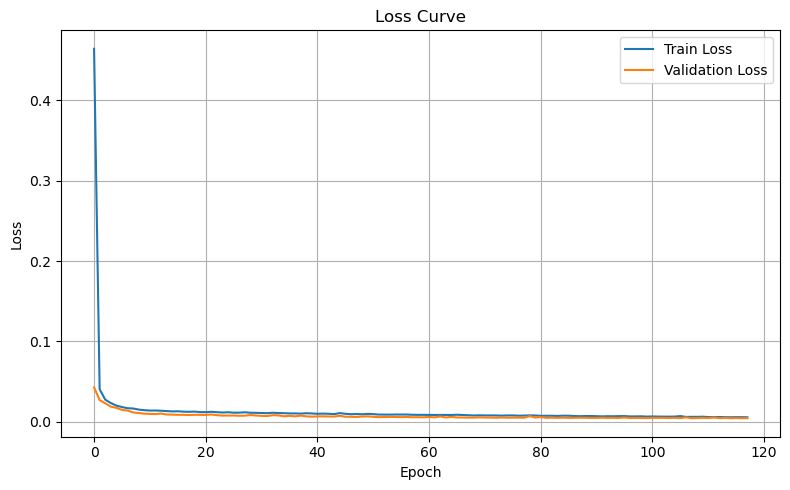

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=3, out_channels=1).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 1000
patience = 10
best_val_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        #print(f"  -> No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# === 損失関数グラフの表示 ===
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


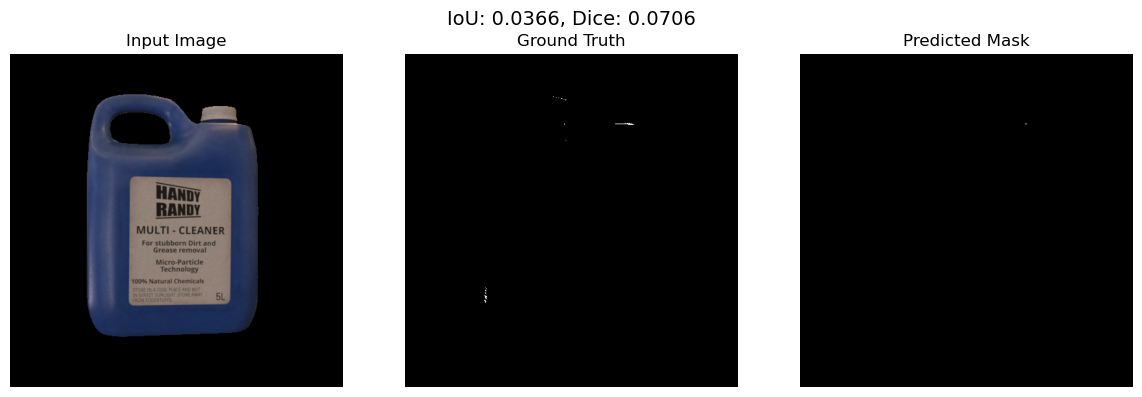

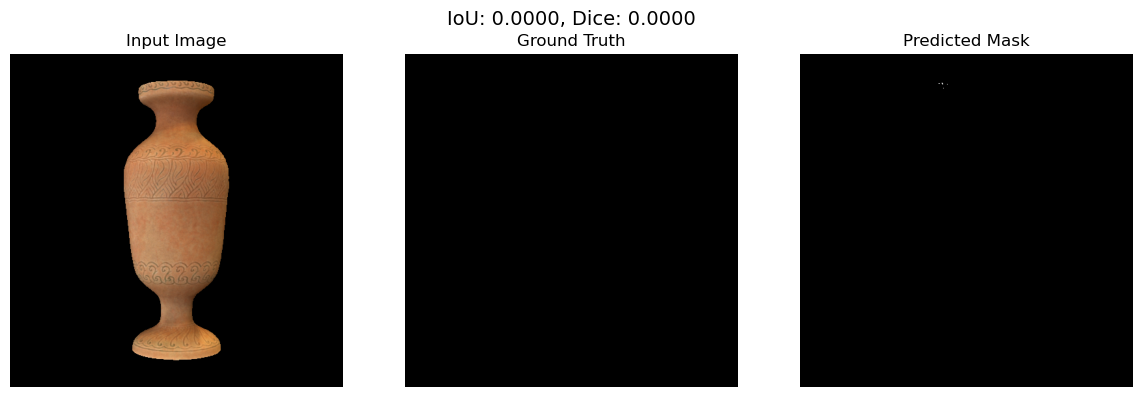

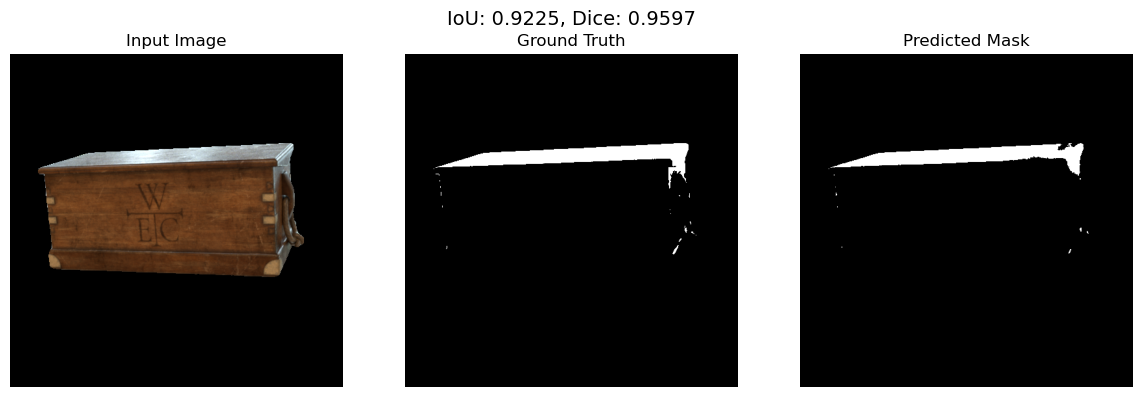

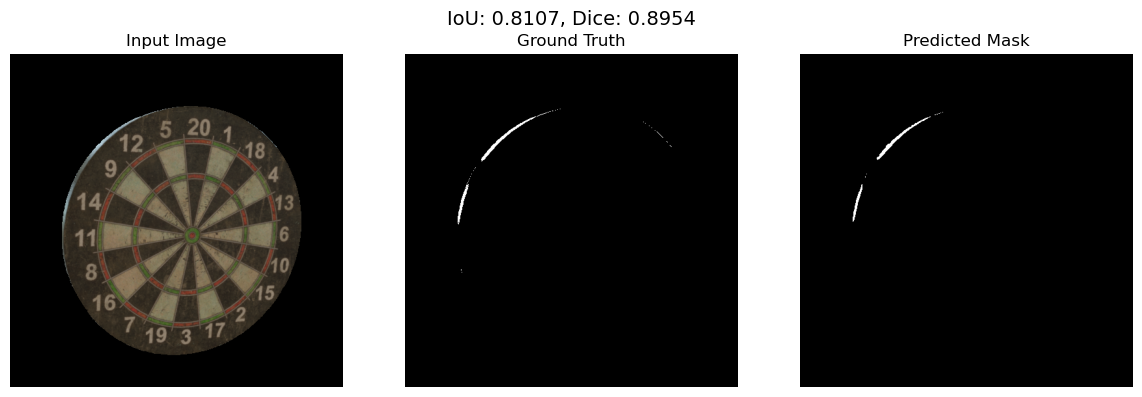

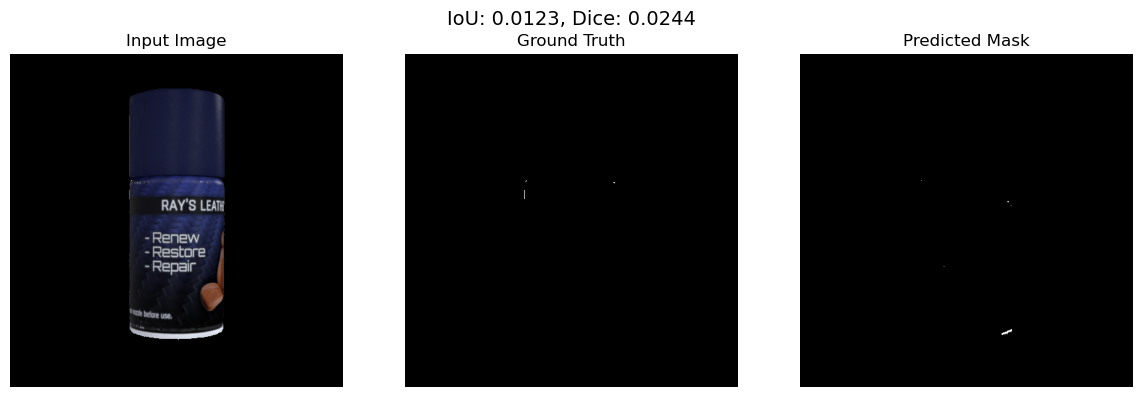

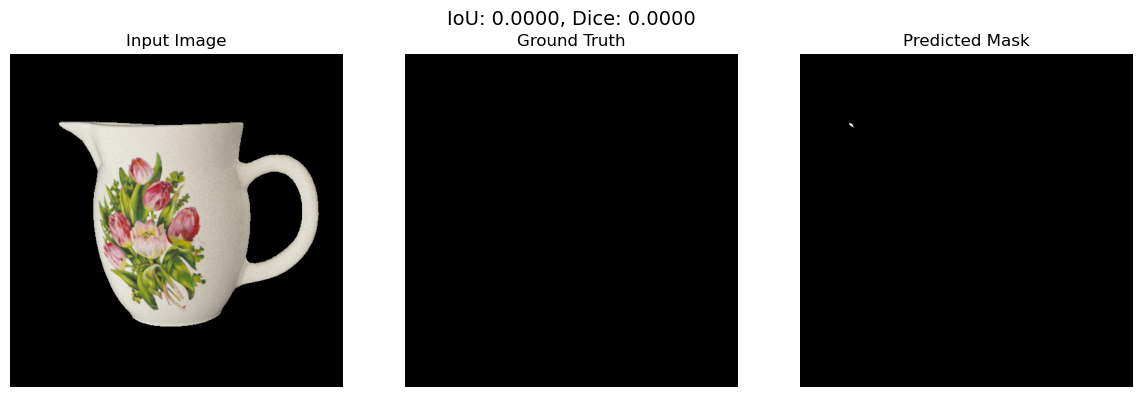

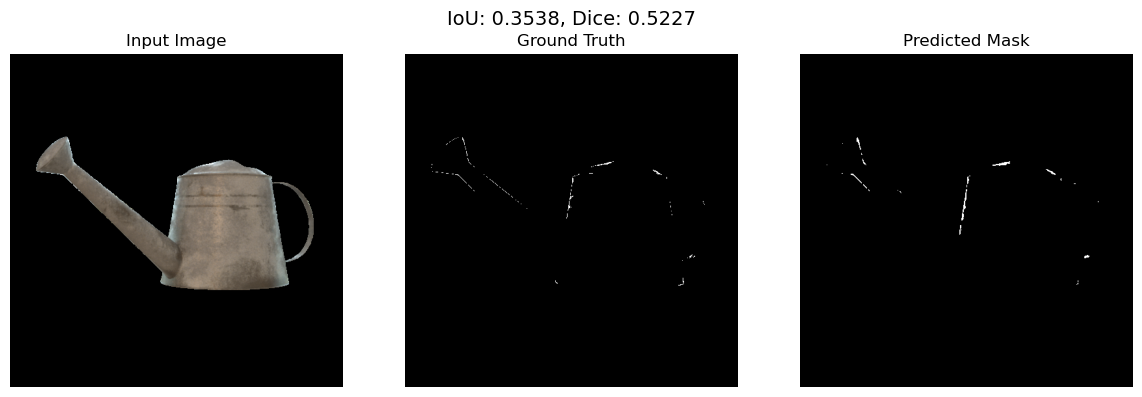

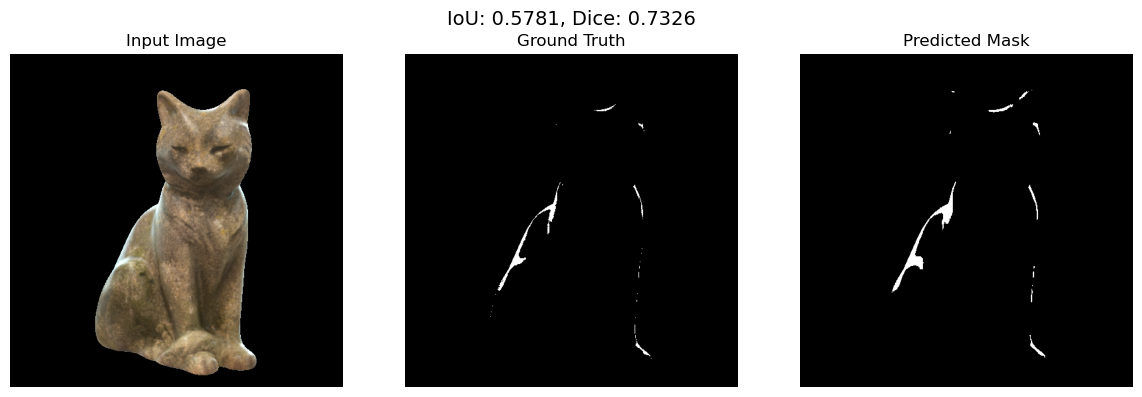

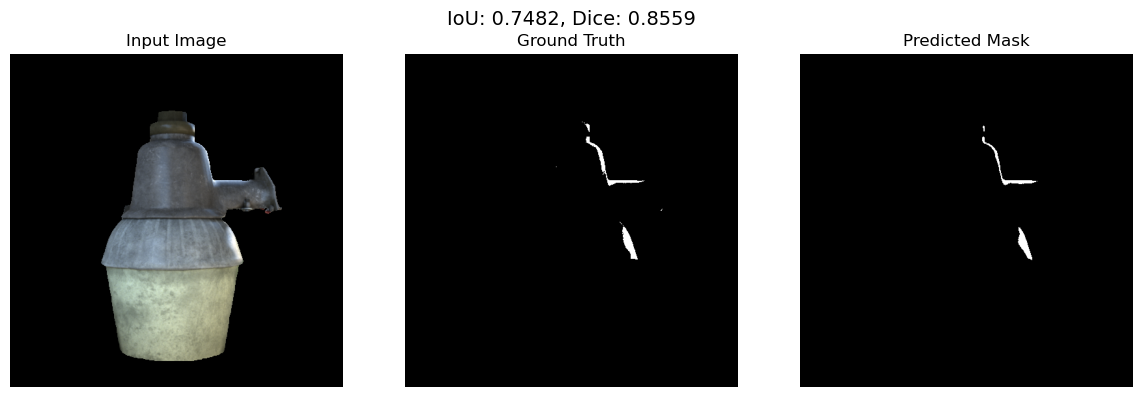

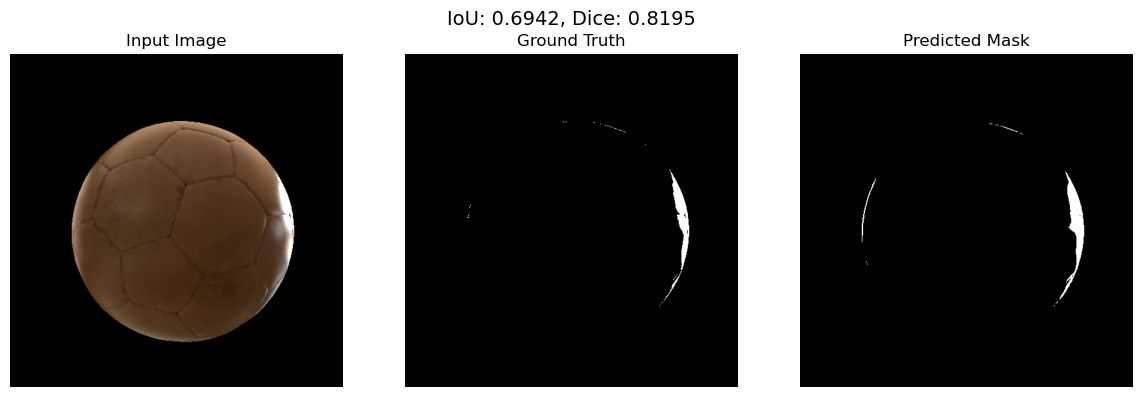

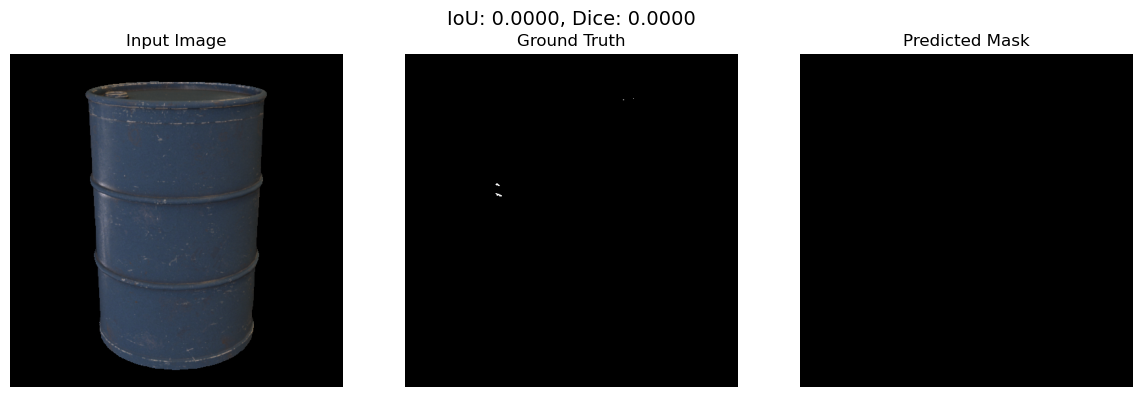

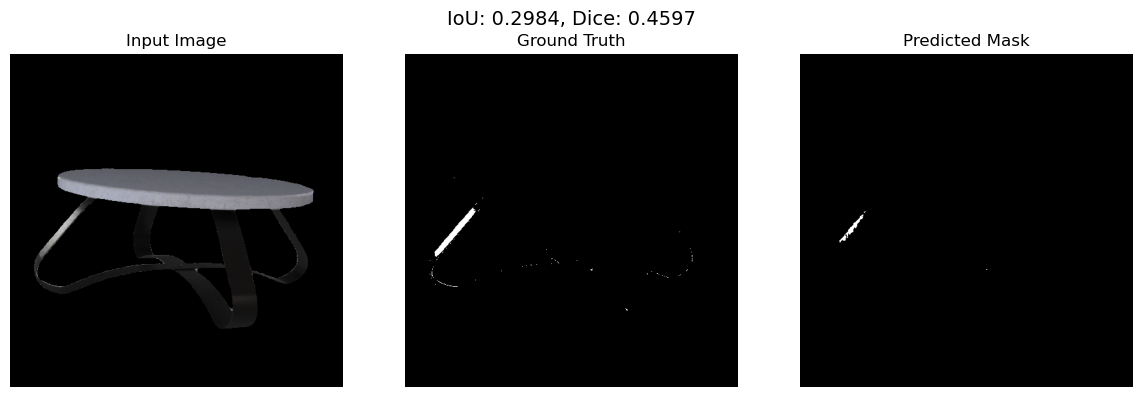

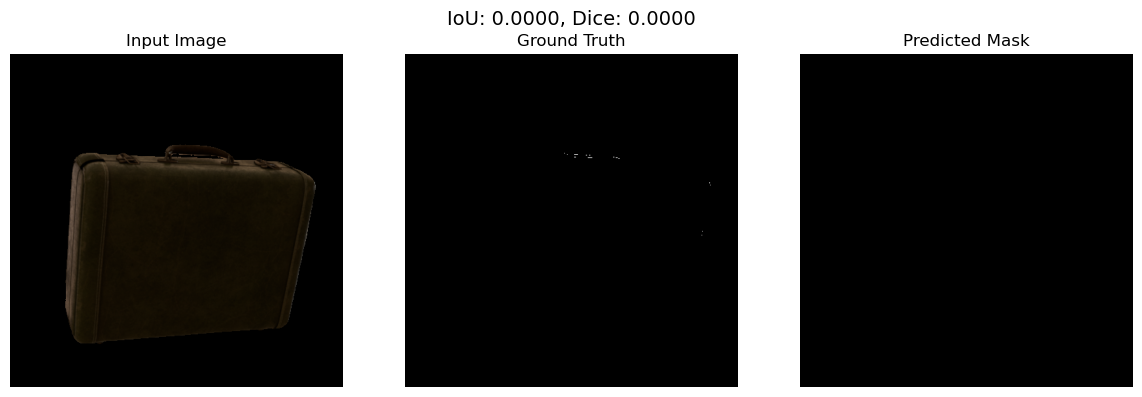

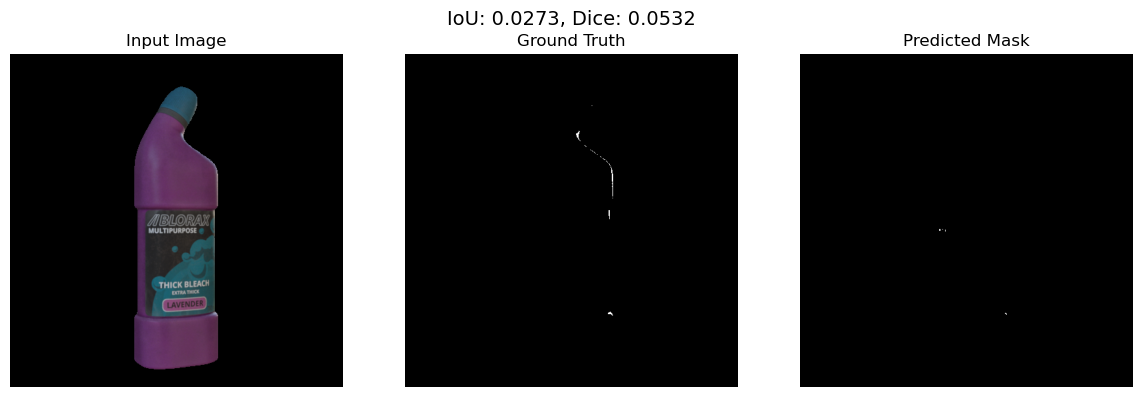

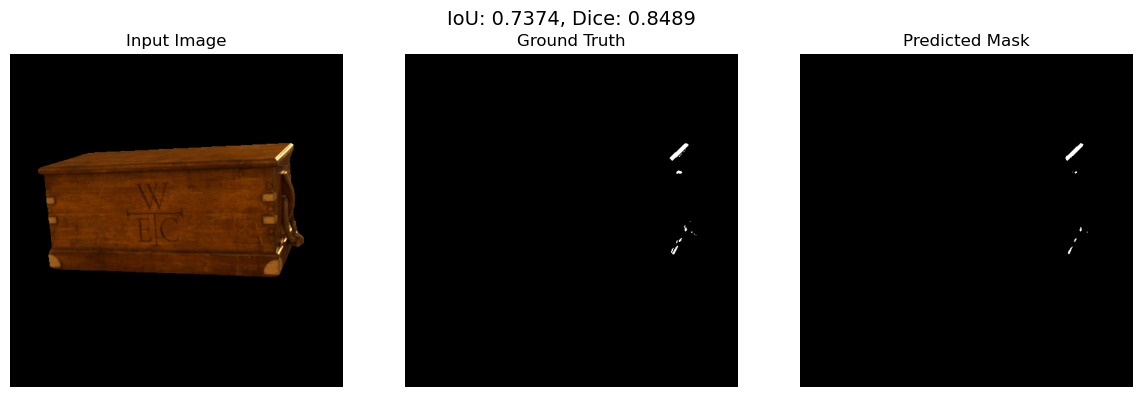

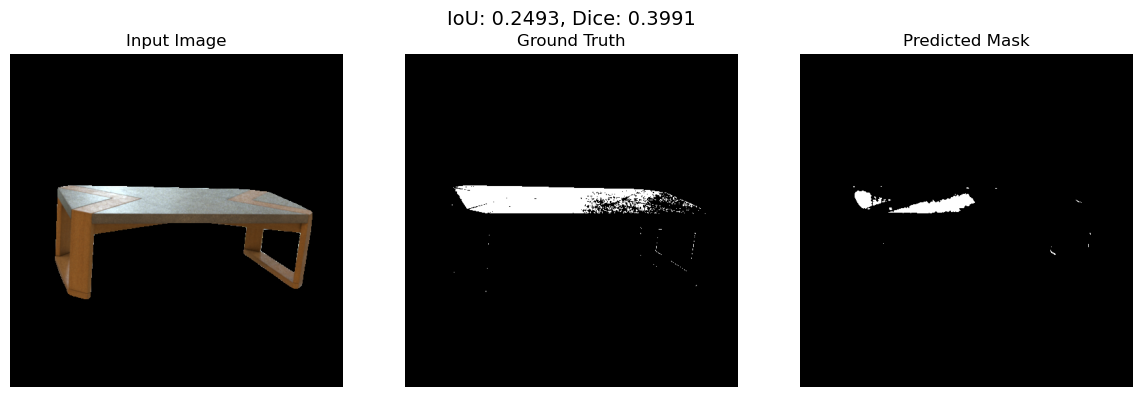

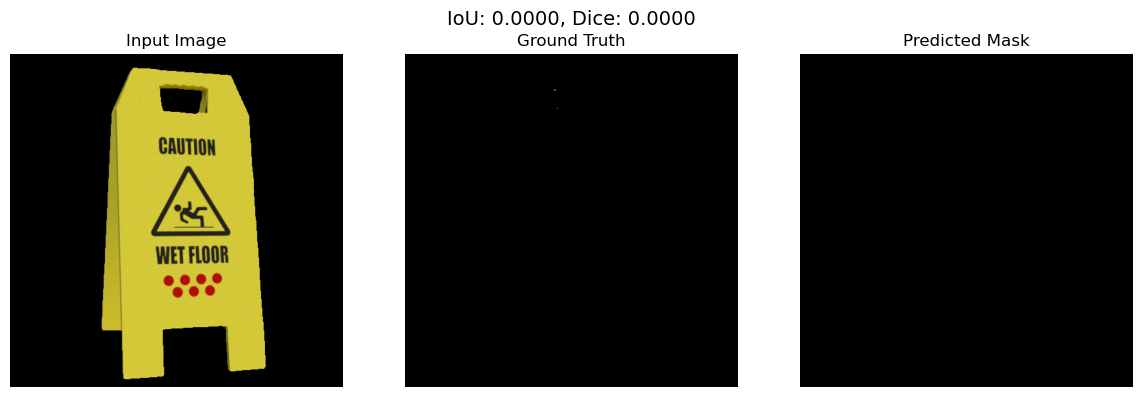

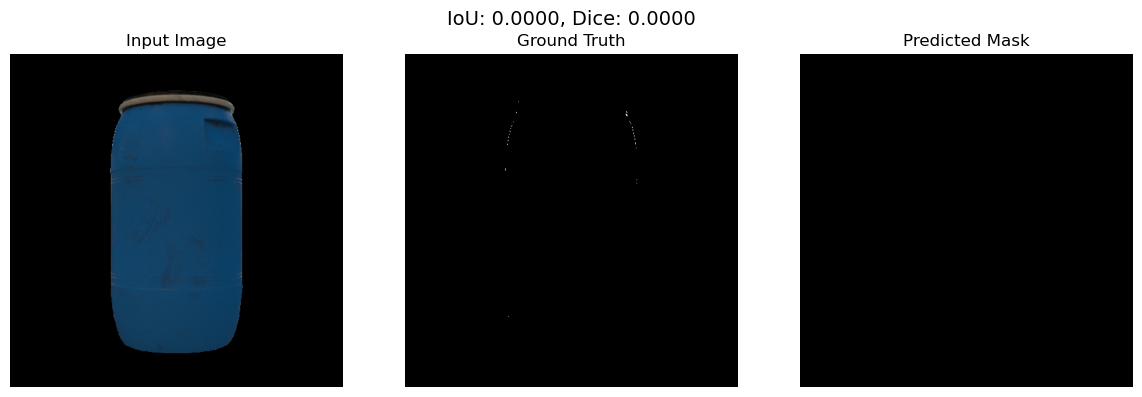

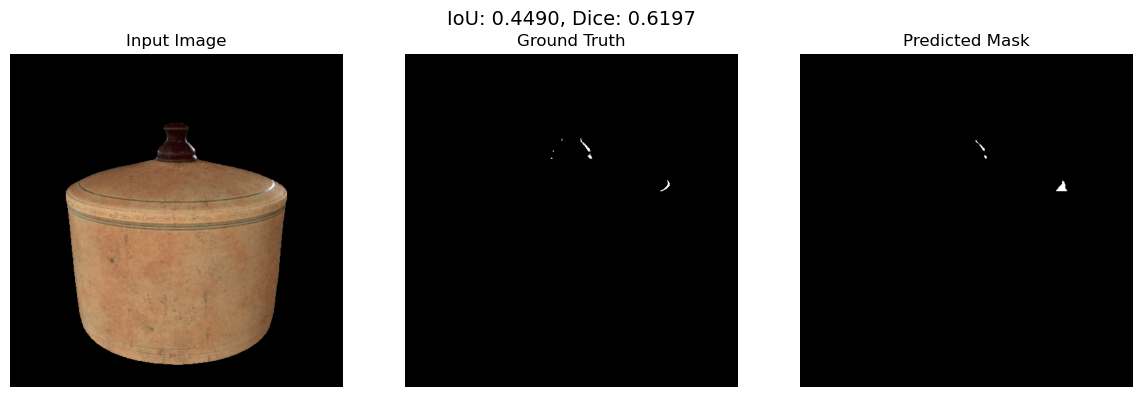

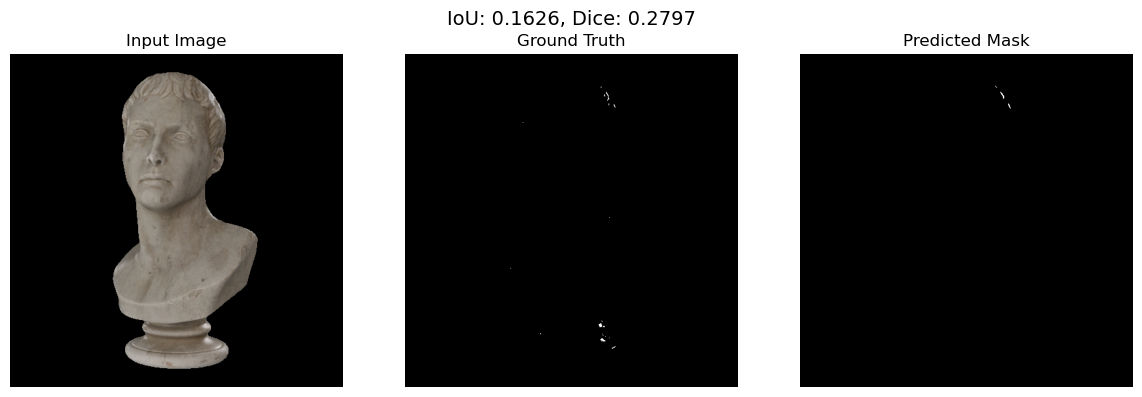

In [17]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def compute_iou(pred, target, eps=1e-6):
    intersection = (pred * target).sum()
    union = (pred + target - pred * target).sum()
    return ((intersection + eps) / (union + eps)).item()

def compute_dice(pred, target, eps=1e-6):
    intersection = (pred * target).sum()
    return ((2 * intersection + eps) / (pred.sum() + target.sum() + eps)).item()

def visualize_batch_predictions(model, dataloader, device, max_images):
    model.load_state_dict(torch.load('best_model.pth', map_location=device))
    model.eval().to(device)

    shown = 0  # 表示済み枚数
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            preds = model(images)
            preds = (preds > 0.5).float()

            batch_size = images.size(0)
            for i in range(batch_size):
                if shown >= max_images:
                    return  # 規定枚数に達したら終了

                image_np = TF.to_pil_image(images[i].cpu())
                mask_np = masks[i].squeeze().cpu().numpy()
                pred_np = preds[i].squeeze().cpu().numpy()

                iou = compute_iou(preds[i], masks[i])
                dice = compute_dice(preds[i], masks[i])

                plt.figure(figsize=(12, 4))
                plt.suptitle(f"IoU: {iou:.4f}, Dice: {dice:.4f}", fontsize=14)

                plt.subplot(1, 3, 1)
                plt.imshow(image_np)
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(mask_np, cmap='gray')
                plt.title("Ground Truth")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(pred_np, cmap='gray')
                plt.title("Predicted Mask")
                plt.axis("off")

                plt.tight_layout()
                plt.show()

                shown += 1  # カウント更新

visualize_batch_predictions(model, test_loader, device=device, max_images=20)


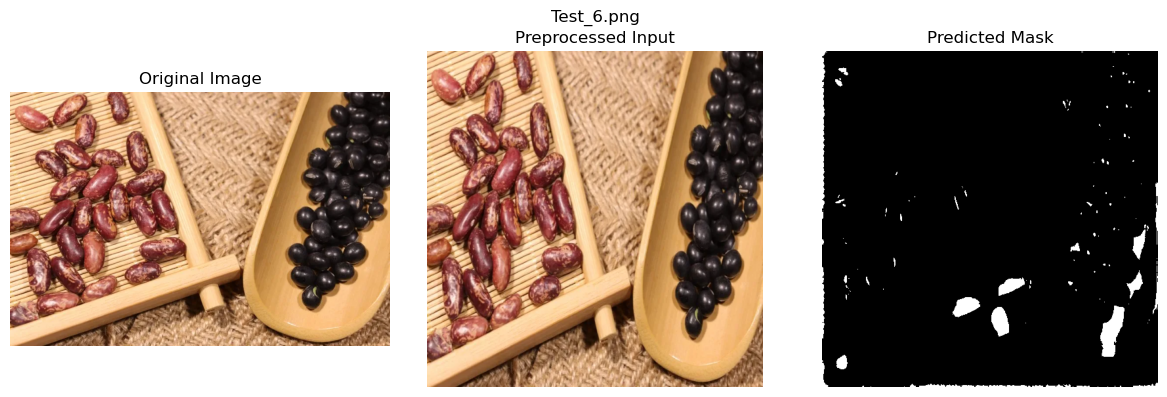

In [16]:
import os
import torch
import random
from PIL import Image
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

# モデルロード
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval().to(device)

# 前処理（表示用の transform は別で保持）
resize_size = (512, 512)
transform = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.ToTensor(),
])

# 画像フォルダとランダム選択
img_dir = "dataset_test"
N = 10  #表示枚数  

all_image_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith('.png')]
image_paths = random.sample(all_image_paths, min(N, len(all_image_paths)))

# 処理ループ
for path in image_paths:
    image = Image.open(path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(input_tensor)
        pred = (pred > 0.5).float()

    # 可視化のための変換
    resized_img = TF.to_pil_image(input_tensor.squeeze(0).cpu())
    pred_np = pred.squeeze().cpu().numpy()

    # 可視化
    plt.figure(figsize=(12, 4))
    plt.suptitle(os.path.basename(path), fontsize=12)

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(resized_img)
    plt.title("Preprocessed Input")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_np, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
